# FREDから経済データを取得+ベイズ時系列解析

In [1]:
using Distributed
addprocs(8)

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [2]:
@everywhere using Mamba

In [3]:
using DataFrames
using Dates
using Distributions
using DotEnv
using HTTP
import ForneyLab.dot2svg
using JSON
using Plots
using Printf

[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/matsueushi/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


## 経済データの取得

In [4]:
DotEnv.config();

In [5]:
timeseries_url = @sprintf(
    "https://api.stlouisfed.org/fred/series/observations?series_id=%s&api_key=%s&file_type=json",
    "IPG2211A2N",
    ENV["FRED_API_KEY"])
r = HTTP.get(timeseries_url)

HTTP.Messages.Response:
"""
HTTP/1.1 200 OK
Content-Type: application/json; charset=UTF-8
Server: Apache
Last-Modified: Wed, 27 Mar 2019 16:21:04 GMT
Expires: Sun, 31 Mar 2019 15:23:00 GMT
x-rate-limit-limit: 120
x-rate-limit-remaining: 120
Date: Sun, 31 Mar 2019 15:23:00 GMT
Transfer-Encoding: chunked
Connection: keep-alive, Transfer-Encoding

{"realtime_start":"2019-03-31","realtime_end":"2019-03-31","observation_start":"1600-01-01","observation_end":"9999-12-31","units":"lin","output_type":1,"file_type":"json","order_by":"observation_date","sort_order":"asc","count":962,"offset":0,"limit":100000,"observations":[{"realtime_start":"2019-03-31","realtime_end":"2019-03-31","date":"1939-01-01","value":"3.3842"},{"realtime_start":"2019-03-31","realtime_end":"2019-03-31","date":"1939-02-01","value":"3.4100"},{"realtime_start":"2019-03-31","realtime_end":"2019-03-31","date":"1939-03-01","value":"3.4875"},{"realtime_start":"2019-03-31","realtime_end":"2019-03-31","date":"1939-04-01","value":

In [6]:
obs_vec = JSON.parse(IOBuffer(r.body))["observations"]

962-element Array{Any,1}:
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-01-01","value"=>"3.3842")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-02-01","value"=>"3.4100")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-03-01","value"=>"3.4875")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-04-01","value"=>"3.5133")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-05-01","value"=>"3.5133")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-06-01","value"=>"3.5650")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-07-01","value"=>"3.5650")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-08-01","value"=>"3.6167")  
 Dict{String,A

In [7]:
obs_df = DataFrame(permutedims(hcat(collect.(values.(obs_vec))...), (2, 1)), Symbol.(collect(keys(obs_vec[1]))))

962×4 DataFrame
│ Row │ realtime_start │ realtime_end │ date       │ value    │
│     │ String         │ String       │ String     │ String   │
├─────┼────────────────┼──────────────┼────────────┼──────────┤
│ 1   │ 2019-03-31     │ 2019-03-31   │ 1939-01-01 │ 3.3842   │
│ 2   │ 2019-03-31     │ 2019-03-31   │ 1939-02-01 │ 3.4100   │
│ 3   │ 2019-03-31     │ 2019-03-31   │ 1939-03-01 │ 3.4875   │
│ 4   │ 2019-03-31     │ 2019-03-31   │ 1939-04-01 │ 3.5133   │
│ 5   │ 2019-03-31     │ 2019-03-31   │ 1939-05-01 │ 3.5133   │
│ 6   │ 2019-03-31     │ 2019-03-31   │ 1939-06-01 │ 3.5650   │
│ 7   │ 2019-03-31     │ 2019-03-31   │ 1939-07-01 │ 3.5650   │
│ 8   │ 2019-03-31     │ 2019-03-31   │ 1939-08-01 │ 3.6167   │
│ 9   │ 2019-03-31     │ 2019-03-31   │ 1939-09-01 │ 3.7200   │
│ 10  │ 2019-03-31     │ 2019-03-31   │ 1939-10-01 │ 3.7200   │
⋮
│ 952 │ 2019-03-31     │ 2019-03-31   │ 2018-04-01 │ 93.4491  │
│ 953 │ 2019-03-31     │ 2019-03-31   │ 2018-05-01 │ 93.2405  │
│ 954 │ 2019-03-31     │ 2019-03-31   │ 2018-06-01 │ 103.3083 │
│ 955 │ 2019-03-31     │ 2019-03-31   │ 2018-07-01 │ 113.3178 │
│ 956 │ 2019-03-31     │ 2019-03-31   │ 2018-08-01 │ 113.2758 │
│ 957 │ 2019-03-31     │ 2019-03-31   │ 2018-09-01 │ 101.5656 │
│ 958 │ 2019-03-31     │ 2019-03-31   │ 2018-10-01 │ 95.3546  │
│ 959 │ 2019-03-31     │ 2019-03-31   │ 2018-11-01 │ 103.6453 │
│ 960 │ 2019-03-31     │ 2019-03-31   │ 2018-12-01 │ 113.2436 │
│ 961 │ 2019-03-31     │ 2019-03-31   │ 2019-01-01 │ 124.8584 │
│ 962 │ 2019-03-31     │ 2019-03-31   │ 2019-02-01 │ 116.0108 │

In [8]:
for x in [:realtime_start, :realtime_end, :date]
    obs_df[x] = Date.(obs_df[x] ,"y-m-d")
end
obs_df[:value] = parse.(Float64, obs_df[:value])

962-element Array{Float64,1}:
   3.3842
   3.41  
   3.4875
   3.5133
   3.5133
   3.565 
   3.565 
   3.6167
   3.72  
   3.72  
   3.7458
   3.7458
   3.7717
   ⋮     
 104.5716
  93.4491
  93.2405
 103.3083
 113.3178
 113.2758
 101.5656
  95.3546
 103.6453
 113.2436
 124.8584
 116.0108

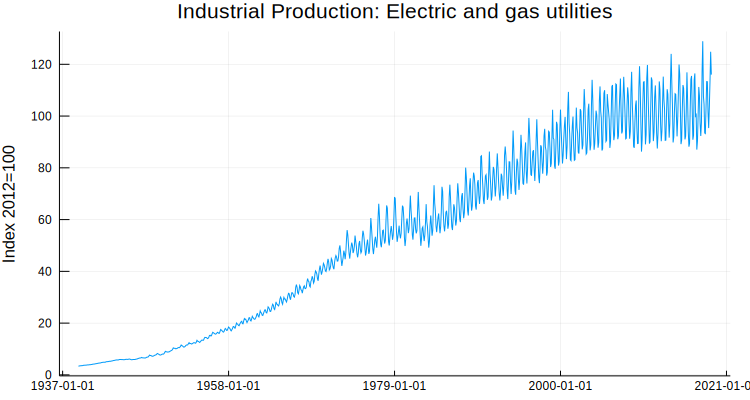

In [9]:
Plots.plot(obs_df[:date], obs_df[:value],
    size = [750, 400],
    title = "Industrial Production: Electric and gas utilities",
    ylabel = "Index 2012=100", 
    label = "")

全データを使うとフィッティングに時間がかかるので、2000年以降のデータを対象とする

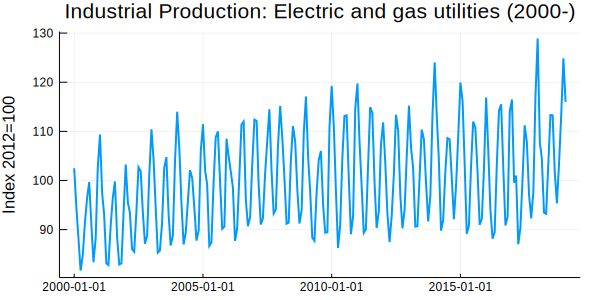

In [10]:
data_df = obs_df[obs_df[:date] .>= Date(2000,1,1), [:date, :value]]
Plots.plot(data_df[:date], data_df[:value],
    size = [600, 300],
    linewidth = 2,
    title = "Industrial Production: Electric and gas utilities (2000-)",
    ylabel = "Index 2012=100", 
    label = "")

## Local Level Model
\begin{align*}
y_t &= T_t + I_t, \\
T_{t+1} &= T_t + a_{T_i}, \\
I_t &\sim \mathcal{N}(0, \sigma_I^2), \\
a_{T_i} &\sim \mathcal{N}(0, \sigma_T^2)\\
T_0 &\sim \mathcal{N}(T_{init}, 100^2) \\
\end{align*}

In [11]:
local_level_model = Model(
    
    obs = Stochastic(1,
        (T, sigma_I) -> MvNormal(T, fill(sigma_I, length(T))),
        false
    ),
    
    T = Logical(1,
        (T_0, disturbance) -> T_0 .+ vcat([0], cumsum(disturbance)),
    ),
    
    disturbance = Stochastic(1,
        (N, sigma_T) -> MvNormal(zeros(N - 1), fill(sigma_T, N - 1)),
        false
    ),
    
    sigma_I = Stochastic(() -> InverseGamma()),
    sigma_T = Stochastic(() -> InverseGamma()),
    
    T_0 = Stochastic(T_init -> Normal(T_init, 100)),
)

Object of type "Model"
-------------------------------------------------------------------------------
T:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
sigma_T:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
sigma_I:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
T_0:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
disturbance:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


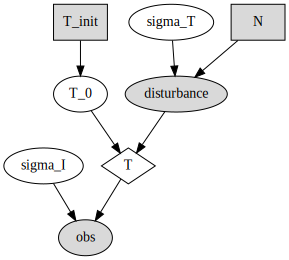

In [12]:
display("image/svg+xml", dot2svg(graph2dot(local_level_model)))

In [13]:
function sample_local_level_model()
    N = 100
    T_0 = rand(Normal(100, 100))
    sigma_I = rand(InverseGamma())
    sigma_T = rand(InverseGamma())
    disturbance = rand(MvNormal(zeros(N - 1), fill(sigma_T, N - 1)))
    T = T_0 .+ vcat([0], cumsum(disturbance))
    obs = rand(MvNormal(T, fill(sigma_I, N)))
    
    Dict(
        :N => N,
        :T_0 => T_0,
        :sigma_I => sigma_I,
        :sigma_T => sigma_T,
        :disturbance => disturbance,
        :T => T,
        :obs => obs,
    )
end

sample_local_level_model (generic function with 1 method)

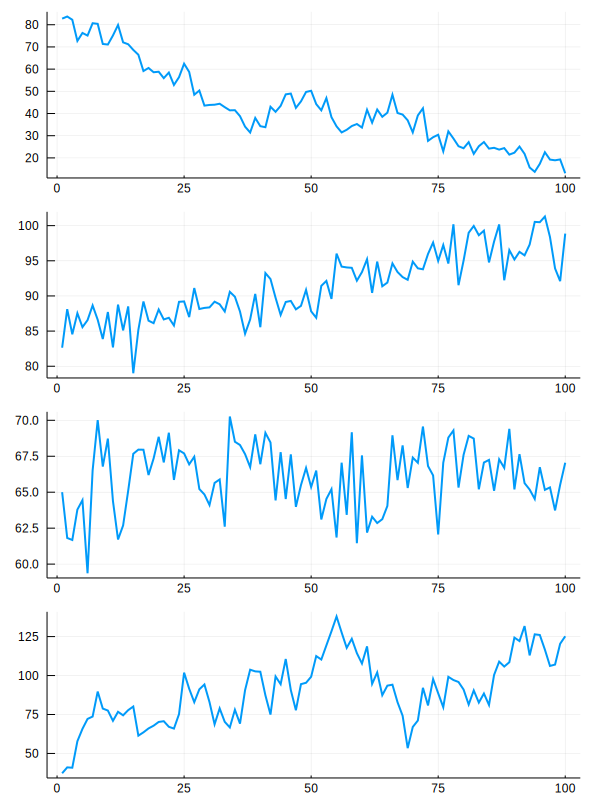

In [14]:
plts = []
for i in 1:4
    sample = sample_local_level_model()
    push!(plts, Plots.plot(sample[:obs], linewidth = 2, label = ""))
end
Plots.plot(plts..., layout = (4, 1), size = [600, 800])

### サンプルに対してフィッティング

In [15]:
local_level_sample = sample_local_level_model()

Dict{Symbol,Any} with 7 entries:
  :T           => [228.112, 228.262, 242.017, 258.998, 285.791, 288.107, 267.31…
  :N           => 100
  :sigma_I     => 0.413735
  :T_0         => 228.112
  :sigma_T     => 14.2026
  :obs         => [228.369, 228.847, 242.018, 258.386, 285.86, 288.005, 267.283…
  :disturbance => [0.150288, 13.7552, 16.9805, 26.793, 2.31618, -20.7953, 18.79…

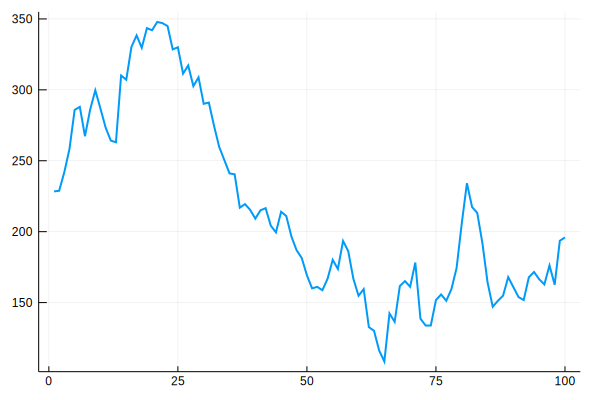

In [16]:
Plots.plot(local_level_sample[:obs], linewidth = 2, label = "")

In [17]:
local_level_sample_data = Dict(
    :obs => local_level_sample[:obs],
    :N => local_level_sample[:N],
    :T_init => local_level_sample[:obs][1],
)

Dict{Symbol,Any} with 3 entries:
  :N      => 100
  :T_init => 228.369
  :obs    => [228.369, 228.847, 242.018, 258.386, 285.86, 288.005, 267.283, 286…

In [24]:
local_level_sample_inits = [
    Dict(
        :obs => local_level_sample[:obs],
        :T => local_level_sample[:obs],
        :disturbance => zeros(local_level_sample[:N] - 1),
        :sigma_I => 1,
        :sigma_T => 1,
        :T_0 => local_level_sample[:obs][1],
    ) for _ in 1:5
]

5-element Array{Dict{Symbol,Any},1}:
 Dict(:T=>[228.369, 228.847, 242.018, 258.386, 285.86, 288.005, 267.283, 286.035, 299.655, 286.772  …  153.895, 151.806, 167.86, 171.588, 166.474, 162.797, 176.217, 162.575, 193.588, 195.94],:sigma_T=>1,:sigma_I=>1,:T_0=>228.369,:obs=>[228.369, 228.847, 242.018, 258.386, 285.86, 288.005, 267.283, 286.035, 299.655, 286.772  …  153.895, 151.806, 167.86, 171.588, 166.474, 162.797, 176.217, 162.575, 193.588, 195.94],:disturbance=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 Dict(:T=>[228.369, 228.847, 242.018, 258.386, 285.86, 288.005, 267.283, 286.035, 299.655, 286.772  …  153.895, 151.806, 167.86, 171.588, 166.474, 162.797, 176.217, 162.575, 193.588, 195.94],:sigma_T=>1,:sigma_I=>1,:T_0=>228.369,:obs=>[228.369, 228.847, 242.018, 258.386, 285.86, 288.005, 267.283, 286.035, 299.655, 286.772  …  153.895, 151.806, 167.86, 171.588, 166.474, 162.797, 176.217, 162.575, 193.588, 195.94],:disturbance

In [25]:
local_level_scheme = [
    AMWG([:disturbance], 1.0), Slice([:sigma_I, :sigma_T, :T_0], 1.0)
]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:disturbance]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Multivariate}}"
Sampling Block Nodes:
Symbol[:sigma_I, :sigma_T, :T_0]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                          

In [26]:
setsamplers!(local_level_model, local_level_scheme)
local_level_sample_sim = mcmc(
    local_level_model, local_level_sample_data, local_level_sample_inits, 
    21000, burnin = 1000, thin = 10, chains = 5)

MCMC Simulation of 21000 Iterations x 5 Chains...

      From worker 2:	Chain 1:   0% [4:16:51 of 4:16:58 remaining]
      From worker 4:	Chain 3:   0% [4:39:58 of 4:40:06 remaining]
      From worker 3:	Chain 2:   0% [4:24:34 of 4:24:42 remaining]
      From worker 9:	Chain 5:   0% [4:31:34 of 4:31:42 remaining]
      From worker 7:	Chain 4:   0% [4:59:27 of 4:59:36 remaining]
      From worker 4:	Chain 3:  10% [0:02:16 of 0:02:31 remaining]
      From worker 9:	Chain 5:  10% [0:02:14 of 0:02:29 remaining]
      From worker 2:	Chain 1:  10% [0:02:20 of 0:02:35 remaining]
      From worker 3:	Chain 2:  10% [0:02:15 of 0:02:30 remaining]
      From worker 7:	Chain 4:  10% [0:02:24 of 0:02:40 remaining]
      From worker 9:	Chain 5:  20% [0:01:24 of 0:01:45 remaining]
      From worker 4:	Chain 3:  20% [0:01:26 of 0:01:48 remaining]
      From worker 2:	Chain 1:  20% [0:01:29 of 0:01:51 remaining]
      From worker 7:	Chain 4:  20% [0:01:30 of 0:01:53 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3,4,5
Samples per chain = 2000

[6.68027 13.8717 … 184.646 190.738; 5.66541 14.2962 … 186.192 194.331; … ; 1.63967 14.4678 … 192.127 195.775; 1.81151 15.3052 … 192.995 196.643]

[6.2004 10.8094 … 194.342 207.916; 6.72939 11.4659 … 191.34 201.005; … ; 2.48828 13.8916 … 195.682 197.769; 2.1793 14.9637 … 195.416 197.503]

[5.27501 12.3406 … 187.491 194.43; 6.64113 12.7456 … 188.184 191.325; … ; 1.75339 14.0997 … 193.25 196.64; 1.79085 13.8062 … 192.167 196.224]

[6.946 10.4543 … 192.25 186.126; 6.93827 11.3806 … 188.22 183.061; … ; 1.95681 14.4609 … 193.675 198.001; 1.92488 14.7282 … 194.733 198.159]

[5.66052 14.6658 … 190.221 191.89; 6.26155 15.3882 … 180.236 190.533; … ; 2.95984 13.9426 … 192.752 195.789; 2.90021 13.9528 … 194.943 191.692]

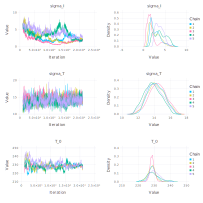

In [27]:
p = Mamba.plot(local_level_sample_sim[:, [:sigma_I, :sigma_T, :T_0], :], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

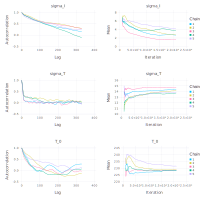

In [28]:
p = Mamba.plot(local_level_sample_sim[:, [:sigma_I, :sigma_T, :T_0], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

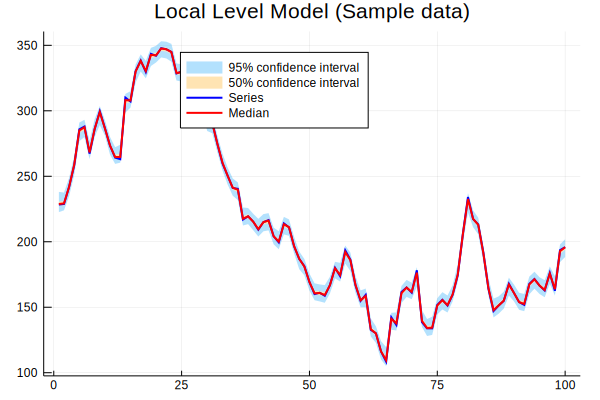

In [29]:
Ts = quantile(local_level_sample_sim[:, [:T], :]).value
Plots.plot(Ts[:, 1, :], 
    fillrange = Ts[:, 5, :], fillalpha = 0.3,
    linewidth = 0, label = "95% confidence interval")
Plots.plot!(Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 1, fillcolor = :white,
    linewidth = 0, label = "")
Plots.plot!(Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 0.3, fillcolor = :orange,
    linewidth = 0, label = "50% confidence interval")
Plots.plot!(local_level_sample[:obs],
    linewidth = 2, linecolor = :blue,
    title = "Local Level Model (Sample data)",
    label = "Series")
Plots.plot!(Ts[:, 3, :], 
    legend = :top,
    linewidth = 2, linecolor = :red, label = "Median")

### FREDから取得したデータに対してフィッティング

In [30]:
local_level_fred_data = Dict(
    :obs => data_df[:value],
    :N => size(data_df, 1),
    :T_init => data_df[:value][1],
)

Dict{Symbol,Any} with 3 entries:
  :N      => 230
  :T_init => 102.497
  :obs    => [102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99…

In [31]:
local_level_fred_inits = [
    Dict(
        :obs => local_level_fred_data[:obs],
        :T => local_level_fred_data[:obs],
        :disturbance => zeros(local_level_fred_data[:N] - 1),
        :sigma_I => 1,
        :sigma_T => 1,
        :T_0 => local_level_fred_data[:T_init],
    ) for _ in 1:5
]

5-element Array{Dict{Symbol,Any},1}:
 Dict(:T=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:sigma_T=>1,:sigma_I=>1,:T_0=>102.497,:obs=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:disturbance=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 Dict(:T=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:sigma_T=>1,:sigma_I=>1,:T_0=>102.497,:obs=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:dis

In [32]:
local_level_fred_sim = mcmc(
    local_level_model, local_level_fred_data, local_level_fred_inits, 
    21000, burnin = 1000, thin = 10, chains = 5)

MCMC Simulation of 21000 Iterations x 5 Chains...

      From worker 3:	Chain 5:   0% [0:06:08 of 0:06:09 remaining]
      From worker 9:	Chain 4:   0% [0:06:20 of 0:06:20 remaining]
      From worker 8:	Chain 2:   0% [4:20:36 of 4:20:44 remaining]
      From worker 5:	Chain 1:   0% [5:01:52 of 5:02:00 remaining]
      From worker 6:	Chain 3:   0% [4:48:08 of 4:48:16 remaining]
      From worker 9:	Chain 4:  10% [0:02:59 of 0:03:19 remaining]
      From worker 3:	Chain 5:  10% [0:03:04 of 0:03:25 remaining]
      From worker 8:	Chain 2:  10% [0:04:27 of 0:04:57 remaining]
      From worker 6:	Chain 3:  10% [0:04:21 of 0:04:50 remaining]
      From worker 5:	Chain 1:  10% [0:04:32 of 0:05:03 remaining]
      From worker 3:	Chain 5:  20% [0:02:45 of 0:03:27 remaining]
      From worker 9:	Chain 4:  20% [0:02:45 of 0:03:27 remaining]
      From worker 8:	Chain 2:  20% [0:03:25 of 0:04:17 remaining]
      From worker 6:	Chain 3:  20% [0:03:21 of 0:04:11 remaining]
      From worker 5:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3,4,5
Samples per chain = 2000

[9.07725 0.897446 … 107.667 107.29; 8.96777 0.792133 … 104.54 105.005; … ; 8.89387 0.758768 … 103.468 102.879; 8.99757 0.565396 … 106.11 106.417]

[9.12201 0.434101 … 102.091 102.062; 9.42854 0.4929 … 103.249 103.7; … ; 9.07455 0.778977 … 104.442 104.846; 9.37277 0.761367 … 103.863 103.782]

[9.45178 0.69738 … 109.436 107.995; 9.07692 0.507151 … 107.557 108.206; … ; 9.29392 0.539055 … 106.279 106.353; 9.52412 0.492266 … 105.248 105.725]

[9.62212 0.664652 … 107.306 107.537; 9.40581 0.723302 … 108.857 109.063; … ; 9.0628 1.21899 … 107.043 107.76; 9.18098 1.16865 … 105.587 105.491]

[9.11848 0.376392 … 103.708 103.894; 9.61892 0.332569 … 102.55 102.947; … ; 9.33101 0.738996 … 105.605 104.352; 9.39742 0.733271 … 104.099 102.778]

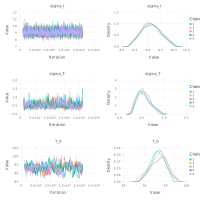

In [33]:
p = Mamba.plot(local_level_fred_sim[:, [:sigma_I, :sigma_T, :T_0], :], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

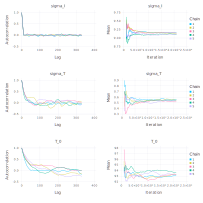

In [34]:
p = Mamba.plot(local_level_fred_sim[:, [:sigma_I, :sigma_T, :T_0], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

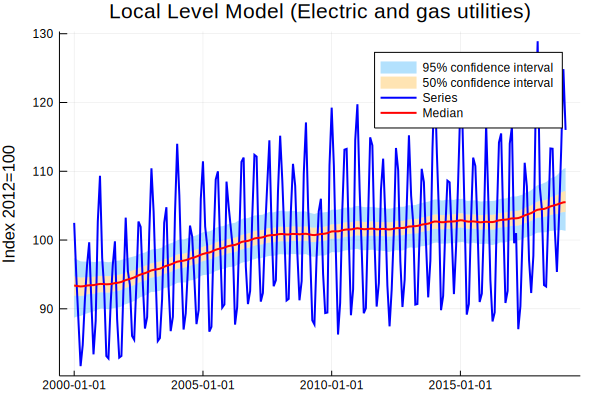

In [35]:
Ts = quantile(local_level_fred_sim[:, [:T], :]).value
Plots.plot(data_df[:date], Ts[:, 1, :], 
    fillrange = Ts[:, 5, :], fillalpha = 0.3,
    linewidth = 0, label = "95% confidence interval")
Plots.plot!(data_df[:date], Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 1, fillcolor = :white,
    linewidth = 0, label = "")
Plots.plot!(data_df[:date], Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 0.3, fillcolor = :orange,
    linewidth = 0, label = "50% confidence interval")
Plots.plot!(data_df[:date], data_df[:value],
    linewidth = 2, linecolor = :blue,
    title = "Local Level Model (Electric and gas utilities)",
    ylabel = "Index 2012=100", 
    label = "Series")
Plots.plot!(data_df[:date], Ts[:, 3, :], 
    linewidth = 2, linecolor = :red, label = "Median")

## Local Linear Model
\begin{align*}
y_t &= T_t + I_t, \\
T_{t+1} &= T_t + \beta_t + a_{T_i}, \\
\beta_{t+1} &= \beta_t + \zeta_t, \\
I_t &\sim \mathcal{N}(0, \sigma_I^2), \\
a_{T_i} &\sim \mathcal{N}(0, \sigma_T^2), \\
T_0 &\sim \mathcal{N}(T_{init}, 100^2), \\
\zeta_t &\sim \mathcal{N}(0, \sigma_\zeta^2), \\
\beta_0 &\sim \mathcal{N}(0, 10^2), \\
\end{align*}

In [37]:
local_linear_model = Model(
          
    obs = Stochastic(1,
        (T, beta, sigma_I) -> MvNormal(T + beta, fill(sigma_I, length(T))),
        false
    ),
    
    T = Logical(1,
        (T_0, disturbance) -> T_0 .+ vcat([0], cumsum(disturbance)),
    ),
    
    beta = Logical(1,
        (beta_0, zeta) -> beta_0 .+ vcat([0], cumsum(zeta)),
        false,
    ),
    
    disturbance = Stochastic(1,
        (N, sigma_T) -> MvNormal(zeros(N - 1), fill(sigma_T, N - 1)),
        false
    ),
    
    zeta = Stochastic(1,
        (N, sigma_zeta) -> MvNormal(zeros(N - 1), fill(sigma_zeta, N - 1)),
        false
    ),
    
    sigma_I = Stochastic(() -> InverseGamma()),
    sigma_T = Stochastic(() -> InverseGamma()),
    sigma_zeta = Stochastic(() -> InverseGamma()),
    
    T_0 = Stochastic(T_init -> Normal(T_init, 100)),
    beta_0 = Stochastic(() -> Normal(0, 10)),
)

Object of type "Model"
-------------------------------------------------------------------------------
T:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
beta:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
zeta:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
sigma_I:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
sigma_T:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
sigma_zeta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
T_0:
A monitored node of type 

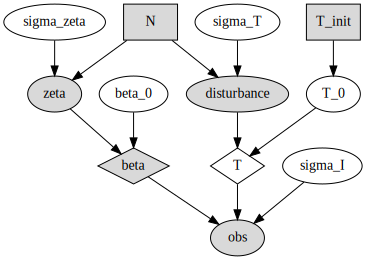

In [38]:
display("image/svg+xml", dot2svg(graph2dot(local_linear_model)))

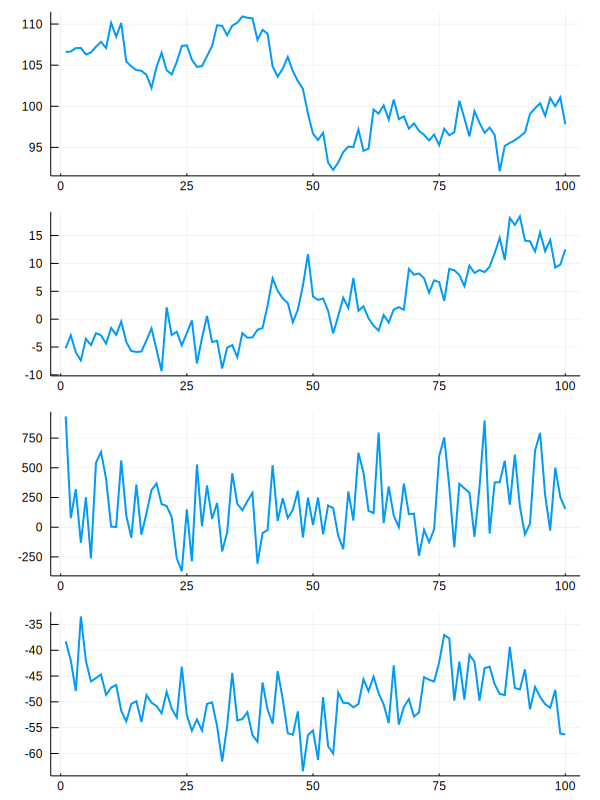

In [39]:
function sample_local_linear_model()
    N = 100
    
    T_0 = rand(Normal(100, 100))
    beta_0 = rand(Normal(0, 10))
    
    sigma_I = rand(InverseGamma())
    sigma_T = rand(InverseGamma())
    sigma_zeta = rand(InverseGamma())
    
    disturbance = rand(MvNormal(zeros(N - 1), fill(sigma_T, N - 1)))
    T = T_0 .+ vcat([0], cumsum(disturbance))
    zeta = rand(MvNormal(zeros(N - 1), fill(sigma_zeta, N - 1)))
    beta = beta_0 .+ vcat([0], cumsum(zeta))
    
    obs = rand(MvNormal(T + beta, fill(sigma_I, N)))
    
    Dict(
        :N => N,
        
        :T_0 => T_0,
        :beta_0 => beta_0,
        
        :sigma_I => sigma_I,
        :sigma_T => sigma_T,
        :sigma_zeta => sigma_zeta,
        
        :disturbance => disturbance,
        :T => T,
        :zeta => zeta,
        :beta => beta,
        
        :obs => obs,
    )
end

plts = []
for i in 1:4
    sample = sample_local_linear_model()
    push!(plts, Plots.plot(sample[:obs], linewidth = 2, label = ""))
end
Plots.plot(plts..., layout = (4, 1), size = [600, 800])

In [40]:
local_linear_fred_data = Dict(
    :obs => data_df[:value],
    :N => size(data_df, 1),
    :T_init => data_df[:value][1],
)

Dict{Symbol,Any} with 3 entries:
  :N      => 230
  :T_init => 102.497
  :obs    => [102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99…

In [42]:
local_linear_fred_inits = [
    Dict(
        :obs => local_linear_fred_data[:obs],
        
        :T => local_linear_fred_data[:obs],
        :disturbance => zeros(local_linear_fred_data[:N] - 1),
        :beta => zeros(local_linear_fred_data[:N]),
        :zeta => zeros(local_linear_fred_data[:N] - 1),
    
        :sigma_I => 1,
        :sigma_T => 1,
        :sigma_zeta => 1,
    
        :T_0 => local_linear_fred_data[:T_init],
        :beta_0 => 0
    ) for _ in 1:5
]

5-element Array{Dict{Symbol,Any},1}:
 Dict(:T=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:beta=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],:zeta=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],:sigma_I=>1,:sigma_T=>1,:sigma_zeta=>1,:T_0=>102.497,:obs=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:beta_0=>0,:disturbance=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]…)
 Dict(:T=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 

In [43]:
local_linear_scheme = [
    AMWG([:disturbance, :beta, :T_0, :beta_0], 1.0), Slice([:sigma_I, :sigma_T, :sigma_zeta], 1.0)
]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:disturbance, :beta, :T_0, :beta_0]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Multivariate}}"
Sampling Block Nodes:
Symbol[:sigma_I, :sigma_T, :sigma_zeta]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                             

In [44]:
setsamplers!(local_linear_model, local_linear_scheme)
local_linear_fred_sim = mcmc(
    local_linear_model, local_linear_fred_data, local_linear_fred_inits, 
    21000, burnin = 1000, thin = 10, chains = 5)

MCMC Simulation of 21000 Iterations x 5 Chains...

      From worker 2:	Chain 1:   0% [0:07:49 of 0:07:49 remaining]
      From worker 3:	Chain 5:   0% [0:07:51 of 0:07:51 remaining]
      From worker 9:	Chain 4:   0% [0:07:51 of 0:07:51 remaining]
      From worker 4:	Chain 2:   0% [0:08:10 of 0:08:10 remaining]
      From worker 7:	Chain 3:   0% [0:11:17 of 0:11:17 remaining]
      From worker 7:	Chain 3:  10% [0:08:43 of 0:09:41 remaining]
      From worker 3:	Chain 5:  10% [0:08:50 of 0:09:48 remaining]
      From worker 9:	Chain 4:  10% [0:08:51 of 0:09:50 remaining]
      From worker 2:	Chain 1:  10% [0:08:52 of 0:09:51 remaining]
      From worker 4:	Chain 2:  10% [0:08:50 of 0:09:49 remaining]
      From worker 2:	Chain 1:  20% [0:07:49 of 0:09:46 remaining]
      From worker 7:	Chain 3:  20% [0:07:49 of 0:09:46 remaining]
      From worker 9:	Chain 4:  20% [0:07:53 of 0:09:51 remaining]
      From worker 3:	Chain 5:  20% [0:07:53 of 0:09:52 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3,4,5
Samples per chain = 2000

[7.20849 3.43113 … 0.0044647 -1.49221; 7.18385 3.44266 … 0.0040266 0.823014; … ; 9.00059 0.689338 … 0.0041229 9.38335; 9.01681 0.636714 … 0.00438537 8.82556]

[9.40892 0.872323 … 0.00423837 -7.67259; 9.40187 0.913312 … 0.00466387 -7.01622; … ; 8.5208 0.49844 … 0.00421217 -6.74284; 8.52489 0.495653 … 0.00428298 -8.1472]

[8.28304 0.833941 … 0.00424656 -0.782257; 8.22819 0.752661 … 0.00417491 -0.955132; … ; 8.69033 0.454562 … 0.00452401 -13.1044; 8.71215 0.501179 … 0.00462734 -13.6758]

[8.54931 0.696428 … 0.00391655 -4.05696; 8.54174 0.704673 … 0.00447928 -1.8559; … ; 8.72803 0.321246 … 0.00482178 -2.65427; 8.72962 0.320723 … 0.00421248 -0.575893]

[8.61084 1.18465 … 0.00460381 16.4213; 8.30239 1.23317 … 0.00438997 17.8333; … ; 9.19375 0.857976 … 0.00504418 12.96; 9.18355 0.852157 … 0.00433439 12.0126]

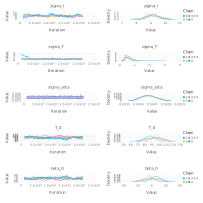

In [45]:
p = Mamba.plot(local_linear_fred_sim[:, [:sigma_I, :sigma_T, :sigma_zeta, :T_0, :beta_0], :], legend = true)
Mamba.draw(p, nrow = 5, ncol = 2)

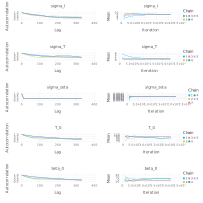

In [46]:
p = Mamba.plot(local_linear_fred_sim[:, [:sigma_I, :sigma_T, :sigma_zeta, :T_0, :beta_0], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 5, ncol = 2)

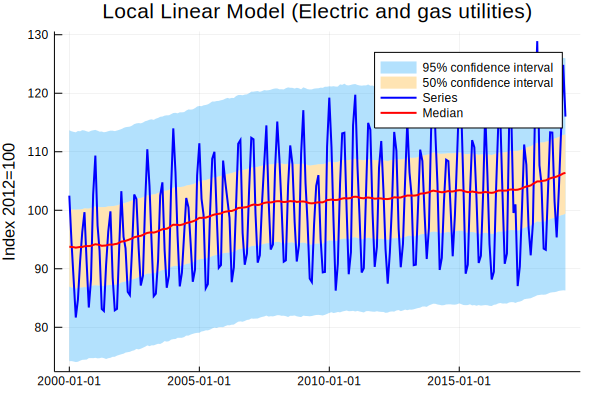

In [47]:
Ts = quantile(local_linear_fred_sim[:, [:T], :]).value
Plots.plot(data_df[:date], Ts[:, 1, :], 
    fillrange = Ts[:, 5, :], fillalpha = 0.3,
    linewidth = 0, label = "95% confidence interval")
Plots.plot!(data_df[:date], Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 1, fillcolor = :white,
    linewidth = 0, label = "")
Plots.plot!(data_df[:date], Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 0.3, fillcolor = :orange,
    linewidth = 0, label = "50% confidence interval")
Plots.plot!(data_df[:date], data_df[:value],
    linewidth = 2, linecolor = :blue,
    title = "Local Linear Model (Electric and gas utilities)",
    ylabel = "Index 2012=100", 
    label = "Series")
Plots.plot!(data_df[:date], Ts[:, 3, :], 
    linewidth = 2, linecolor = :red, label = "Median")